# 前言

聪明钱因子模型的核心逻辑是，从分钟行情数据的价量信息中，尝试识别机构参与交易的多寡，最终构造出一个跟踪聪明钱的选股因子。聪明钱因子的优点：一，模型逻辑简洁，样本内表现良好；其二，模型首次提出了“高频数据，低频因子”的研究模式，是高频因子领域的引领之作。

聪明钱因子模型的核心问题是，如何识别聪明钱的交易。大量的实证研究表明， 聪明钱在交易过程中往往呈现“单笔订单数量更大、订单报价更为激进”的基本特征。基于这个考虑，我们构造了用于度量交易聪明度的指标S（表 1，步骤 2），指标S的数值越大，则认为该分钟的交易中有越多聪明钱参与。借助指标S，我们通过以下方法筛选聪明钱的交易：对于特定股票、特定时段的所有分钟行情数据，将其按照指标S从大到小进行排序，将成交量累积占比前 20%视为聪明钱的交易(表1,步骤3)。

|步骤|说明|
|--|--|
|步骤1|对选定股票，回溯取其过去 10 个交易日的分钟行情数据；|
|步骤2|构造指标$S_t = |R_t|/\sqrt{V_t}$，其中𝑅𝑡为第t分钟涨跌幅，𝑉𝑡为第t分钟成交量；|
|步骤3|将分钟数据按照指标St从大到小进行排序，取成交量累积占比前20%的分钟， 视为聪明钱交易；|
|步骤4|计算聪明钱交易的成交量加权平均价$VWAP_{smart}$；|
|步骤5|计算所有交易的成交量加权平均价$VWAP_{all}$；|
|步骤6|聪明钱因子Q = $VWAP_{smart}/VWAP_{all}$。|

为了更形象地展示这个划分过程，图1中我们给出了一个简单示例。图1的上半部分：这是一段长度为*半小时*的分钟行情数据，按照时间顺序排列，时间标签依次标为 1-30，蓝柱代表每分钟的成交量，红点代表每分钟的S指标值。图1的下半部分：我们按照S值从大到小对原始行情数据进行了重新排序，柱子仍代表每分钟的成交量，绿线代表成交量从左到右的累计占比（相对于总成交量）；以成交量累计占比20%作为划分的界线，将最左侧的6个分钟数据（红柱）划归为聪明钱的交易，剩余的其他分钟数据（蓝柱）则被划为普通资金的交易。

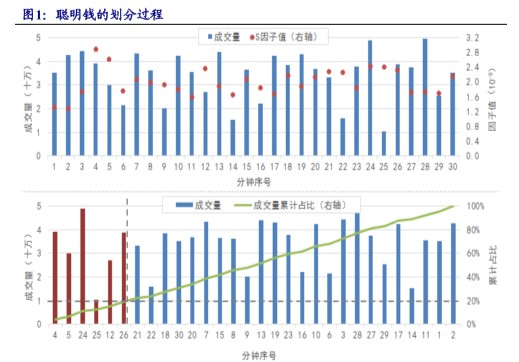

从"量-价"相空间的视角，我们可以更直观地感受S指标在划分过程中起到的作用。在图2中，横坐标为分钟成交量V，纵坐标为分钟涨跌幅的绝对值|R|，每个散点代表一个分钟交易。在最终的划分结果中，红色散点为聪明钱交易，蓝色散点为普通交易，虚线为划分两种交易的分界线。不难发现，分界线的形状直接取决于S指标的构造方式——假设成交量累积占比恰好为20%的分钟交易的S指标值为S0， 则分界线表达式为$|R| = S_0\sqrt{V}$。不同的 S 指标的构造方式，将产生不同的聪明钱划分结果。

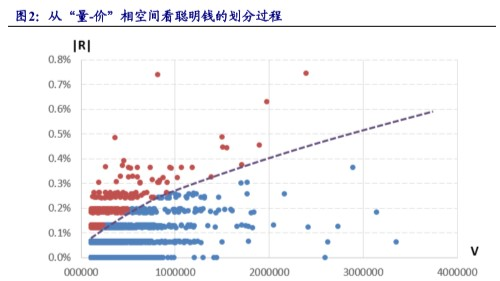

**1. 引入所需的库**

In [1]:
# 引入库
import sys
sys.path.append('../../..')

from BuildPeriodDate import (GetTradePeriod,tdaysoffset)

import numpy as np
import pandas as pd
import empyrical as ep
import alphalens as al
import scipy.stats as st
import alphalens.performance as perf
from alphalens.utils import print_table

from jqdata import *
from jqfactor import (Factor,calc_factors)

import itertools
from typing import (Tuple,List,Dict,Union,Callable)
from functools import reduce
from tqdm import tqdm_notebook
from dateutil.parser import parse


import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt


mpl.rcParams['font.family']='serif' # pd.plot中文
# 用来正常显示负号
mpl.rcParams['axes.unicode_minus'] = False
# 图表主题
plt.style.use('seaborn')

**2.股票池过滤**

1. 过滤上述不足60日的次新;
2. 过滤停牌10日的股票
3. 过滤ST

In [2]:
# 获取股票池
def get_stockpool(symbol: str, watch_date: str) -> list:
    '''获取股票池'''

    if symbol == 'A':
        stockList = get_index_stocks('000001.XSHG', date=watch_date) + get_index_stocks(
            '399107.XSHE', date=watch_date)
    else:
        stockList = get_index_stocks(symbol, date=watch_date)
        
    stockList = del_st_stock(stockList, watch_date)  # 过滤ST
    stockList = del_iponday(stockList, watch_date)   # 过滤上市不足60日
    stockList = del_pause(stockList,watch_date)      # 过滤当日停牌的股票
    return stockList

def del_st_stock(securities: list, watch_date: str) -> list:
    '''过滤ST股票'''

    info_ser = get_extras('is_st', securities,
                          end_date=watch_date, df=True, count=1).iloc[0]

    return info_ser[info_ser == False].dropna().index.tolist()

def del_iponday(securities: list, watch_date: str, N: int = 60) -> list:
    '''返回上市大于N日的股票'''
    dic = {x: get_security_info(x, date=watch_date).start_date for x in securities if get_security_info(
        x, date=watch_date) != None}
    return [code for code, start_date in dic.items() if (parse(watch_date).date() - start_date).days > N]

def del_pause(securities:list,watch_date:str,N:int=10)->list:
    
    '''
    过滤停牌股,默认为过滤当日停牌的
    '''
    
    paused = get_price(securities,end_date=watch_date,count=N,fields='paused',panel=False)
    
    if N == 1:
        return paused.query('paused != 1')['code'].values.tolist()
    else:
        
        paused_num = paused.groupby('code')['paused'].sum()
        return paused_num[paused_num < N].index.values.tolist()

**3. 因子获取**

In [8]:
# 因子计算
def prepare_data(symbol: str, start: str, end: str, last_date: str, 
                 factor: Callable, grid_func_params: Dict,mod='normal') -> pd.DataFrame:
    '''
    symbol:股票池所属成份，A为全市场
    start,end:回测区间 频率为月度
    last_date:计算next_returns的最后一日的日期
    factor:构建的因子
    '''
    periods = GetTradePeriod(start, end, 'ME')  # 月度_周期获取
    periods = periods + [last_date]
    factor_dic = {}

    for tradeDate, nextDate in tqdm_notebook(zip(periods[:-1], periods[1:]), total=len(periods)-1, desc='因子计算'):

        # 股票池
        stock_pool = get_stockpool(symbol, tradeDate.strftime('%Y-%m-%d'))

        # 因子获取

        f = factor(securities=stock_pool, watch_date=tradeDate,mod=mod)
        
        # 获取数据 这里仅需获取一次就能使用该数据进行N此不同参数运算
        f.get_data() 
        # 可以使用不同参数进行计算
        factor_frame = grid_func_params['func'](
            f, **grid_func_params['params'])

        # 计算下期收益率
        close = get_price(stock_pool, end_date=tradeDate, count=1,
                          fields='close', panel=False).set_index('code')

        next_close = get_price(stock_pool, end_date=nextDate,
                               count=1, fields='close', panel=False).set_index('code')

        next_returns = next_close['close'] / close['close'] - 1
        next_returns.name = 'next_ret'

        # 合并
        tmp = pd.concat((factor_frame, next_returns), axis=1,sort=True)
        factor_dic[tradeDate] = tmp  # 放入容器

    factor_df = pd.concat(factor_dic,sort=True)

    factor_df.index.names = ['date', 'code']

    return factor_df


def dict2frame(dic: dict) -> pd.DataFrame:
    '''将data的dict格式转为df'''

    df = pd.concat((df.iloc[-1] for df in dic.values()), axis=1)
    df.columns = list(dic.keys())

    return df

**4. 工具类**

In [9]:
# 计算ic
def src_ic(df:pd.DataFrame)->pd.DataFrame:
    
    '''计算IC'''
    
    f = [col for col in df.columns if col != 'next_ret']
    
    _ic = df[f].apply(lambda x:st.spearmanr(x,df['next_ret'])[0])
    
    return _ic

# 获取分组
def add_group(ser: pd.Series, N: int = 5) -> pd.Series:

    name = ['G%s' % x for x in range(1, N+1)]
    return pd.qcut(ser, N, labels=name,duplicates='drop')

# 获取分组收益率
def get_algorithm_ret(factor_df: pd.DataFrame, col: str) -> pd.DataFrame:

    group_ser = factor_df.groupby(level='date')[col].apply(add_group)
    group_df = pd.concat((factor_df['next_ret'], group_ser), axis=1)

    group_ret = pd.pivot_table(group_df.reset_index(
    ), index='date', columns=col, values='next_ret')
    group_ret.columns = list(map(str, group_ret.columns))
    group_ret['excess_ret'] = group_ret['G1'] - group_ret['G5']

    return group_ret

# 获取多空收益
def get_excess_ret(factor_df: pd.DataFrame, col: list) -> pd.DataFrame:

    if isinstance(col, (str, float, int)):
        col = [col]

    df = pd.concat((get_algorithm_ret(factor_df, x)[
                   'excess_ret'] for x in col), axis=1)
    df.columns = col
    return df

# 风险指标
def risk_indicator_tear(returns:pd.DataFrame,period:str='monthly')->pd.DataFrame:
    
    tear = pd.DataFrame()
    tear['annual_return'] = ep.annual_return(returns,period)
    tear['annual_volatility'] = returns.apply(lambda x:ep.annual_volatility(x,period))
    tear['max_drawdown'] = returns.apply(lambda x:ep.max_drawdown(x))
    
    if 'benchmark' in returns.columns:
        
        select_col = [col for col in returns.columns if col != 'benchmark']

        tear['IR'] = returns[select_col].apply(
            lambda x: information_ratio(x, returns['benchmark']))
    
    return tear

def information_ratio(returns, factor_returns):
    """
    Determines the Information ratio of a strategy.

    Parameters
    ----------
    returns : :py:class:`pandas.Series` or pd.DataFrame
        Daily returns of the strategy, noncumulative.
        See full explanation in :func:`~empyrical.stats.cum_returns`.
    factor_returns: :class:`float` / :py:class:`pandas.Series`
        Benchmark return to compare returns against.

    Returns
    -------
    :class:`float`
        The information ratio.

    Note
    -----
    See https://en.wikipedia.org/wiki/information_ratio for more details.

    """
    if len(returns) < 2:
        return np.nan

    active_return = _adjust_returns(returns, factor_returns)
    tracking_error = np.std(active_return, ddof=1)
    if np.isnan(tracking_error):
        return 0.0
    if tracking_error == 0:
        return np.nan
    return np.mean(active_return) / tracking_error

def _adjust_returns(returns, adjustment_factor):
    """
    Returns a new :py:class:`pandas.Series` adjusted by adjustment_factor.
    Optimizes for the case of adjustment_factor being 0.

    Parameters
    ----------
    returns : :py:class:`pandas.Series`
    adjustment_factor : :py:class:`pandas.Series` / :class:`float`

    Returns
    -------
    :py:class:`pandas.Series`
    """
    if isinstance(adjustment_factor, (float, int)) and adjustment_factor == 0:
        return returns.copy()
    return returns - adjustment_factor

**5. 因子构建**

**对开跟号的修正 这算是对初始聪明钱因子的改进方案**

在聪明钱因子的构造步骤中，S指标的计算公式为$S = |R|/\sqrt{V}$，分母为分钟成交量V的开根号。我们选择开根号的初衷是：（1）开根号有简单清晰的数学图像可对 应；（2）大量的实证研究表明，价格变化与成交量的平方根之间存在正比关系。
为了方便讨论，我们不妨尝试一般化，将分钟成交量V的指数项定义为可变的
参数，这样 S 指标公式可以写成如下形式：$S = |R|/(V^\beta)$其中，R为分钟涨跌幅，V 为分钟成交量，β为分钟成交量V的指数项参数。
不难看出，当β取值为0.5时即为原始聪明钱因子S指标；当β取值为0时，S指标
可以写为 S=|R|；当β取值为-0.5 时，S指标可以写为$S = |R| ∗ \sqrt{V}$的乘积形式。

In [10]:
# 聪明钱因子
class Q_factor(object):

    def __init__(self, securities: Union[str, list], watch_date: str, N: int = 10, frequency: str = '30m',mod:str='normal') -> None:

        self.securities = securities
        self.watch_date = watch_date
        self.frequency = frequency
        self.N = N
        self._get_count()
        self.mod = mod # normal传统 ln对数

    def get_data(self):

        self.data = get_price(self.securities,
                              end_date=self.watch_date,
                              count=self.minute_count * self.N, frequency='30m',
                              fields=['close', 'volume', 'open'],
                              panel=False)

    def _get_count(self):
        
        '''计算一日需要多少个周期'''
        ALL_DAY = 240  # 一个完整交易日分钟数

        if self.frequency[-1] != 'm':

            raise ValueError('frequency参数必须是X minute(X必须是整数)')

        self.minute_count = ALL_DAY / int(self.frequency.replace('m', ''))

    def calc(self, beta: float) -> pd.Series:
        
        self.beta = round(beta,2)
        # 文章貌似没说涨停股的处理...如果涨停对此因子的影响应该很大
        data = (self.data.query('volume != 0')
                         .pivot(index='time', columns='code'))

        close_df = data['close']
        vol_df = data['volume']
        open_df = data['open']

        ret_df = close_df / open_df - 1
        abs_ret = ret_df.abs()
        
        if self.mod == 'normal':
            
            # St = |Rt|/√Vt，其中𝑅𝑡为第 t 分钟涨跌幅，𝑉𝑡为第 t 分钟成交量
            S = abs_ret / vol_df.pow(beta)
            
        else:
            
            # 分钟涨跌幅绝对值除以分钟成交量对数值
            S = abs_ret / np.log(vol_df)
            
        # 降序排列【从大到小排序】
        S_rank = S.rank(ascending=False)

        concat_df = pd.concat(
            (S_rank.stack(), vol_df.stack(), close_df.stack()), axis=1, sort=True)
        concat_df.columns = ['rank', 'vol', 'close']
        
        ser = concat_df.groupby(level='code').apply(self.calc_Q)
        ser.name = self.name
        return ser

    # @staticmethod
    def calc_Q(self, df: pd.DataFrame) -> float:

        def vwap(df: pd.DataFrame) -> float:
            
            '''计算vwap'''
            
            try:
                
                v = np.average(df['close'], weights=df['vol'])
                
            except ZeroDivisionError:
                
                print(self.watch_date)
                print(df)
                print(sort_df['vol'])
                raise ValueError('ZeroDivisionError')
                
            return v
        
        def _add_flag(sort_df: pd.DataFrame) -> pd.Series:
            '''
            标记将分钟数据按照指标St从大到小进行排序，
            取成交量累积占比前20%的分钟
            '''

            cum_df = sort_df['vol'].cumsum() / sort_df['vol'].sum()

            cond = (cum_df <= 0.2)

            if (sort_df[cond].empty) and (cum_df.iloc[0] > 0.2):

                return sort_df.iloc[:1, :]

            return sort_df[cond]
    
        
        # 将分钟数据按照指标St从大到小进行排序，取成交量累积占比前20%的分钟,视为聪明钱交易
        sort_df = (df.reset_index()
                     .set_index('rank')
                     .sort_index())

        smart_df = _add_flag(sort_df)
        # 计算聪明钱交易的成交量加权平均价VWAPsmart
        vwap_smart = vwap(smart_df)
        # 计算所有交易的成交量加权平均价VWAPall
        vwap_all_f = vwap(sort_df)

        return vwap_smart / vwap_all_f
    
    @property
    def name(self)->str:
        
        return f'Q_{self.N}_{self.frequency}_{self.beta}'

    


# 因子参数构造
def grid_factor(factor: Callable, lamb: Union[float, list]) -> pd.DataFrame:

    if isinstance(lamb, (float, int)):
        lamb = [lamb]

    df_list = []
    for l in lamb:

        df_list.append(factor.calc(l))

    return pd.concat(df_list, axis=1,sort=True)

In [28]:
# 这个时间有点夸张 5h01m
lamb = [-0.5,-0.25,-0.1,-0.05,0,0.05,0.1,0.25,0.33,0.5,0.7]
factor_data = prepare_data('A','2014-01-01','2020-12-31','2021-01-31',
                           Q_factor,{'func':grid_factor,'params':{'lamb':lamb}})

In [29]:
# 数据储存
# factor_data.to_csv('smart_f.csv')

我们选取若干不同β值分别构造S指标，计算对应聪明钱因子，并对因子进行绩效回测。因子历史回测的基本框架为：回测时段为 2014年1月30日至2020年12月31日；样本空间为全体 A 股，剔除 ST 股和上市未满 60 日的新股；每月月末调仓，持仓一个自然月。

从不同$\beta$值的IC均值上看，当β为 0.7 时，因子IC均值在0左右，因子几乎无 效；随着$\beta$值的逐渐减小，因子IC均值的绝对值逐渐增大，最后达到一个饱和的平台。可以看出，原始聪明钱因子（β=0.5）的选股能力，远远没有达到最优的状态。

In [41]:
# 计算各β下的IC
ic_df = factor_data.groupby(level='date').apply(src_ic)

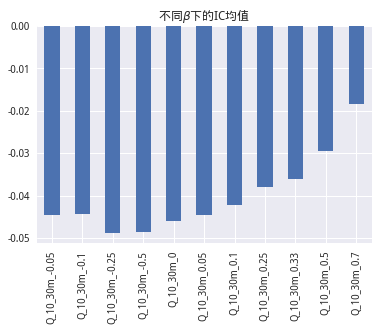

In [48]:
# 画图
ic_df.mean().plot.bar(color='#4C72B0',title=r'不同$\beta$下的IC均值');

为了进一步评价因子的选股能力，我们回测了不同\beta值下的聪明钱因子多空对冲信息比率和多空对冲净值曲线。可以看出，当$\beta$由0.7逐渐减小时，信息比率逐渐增加，当β取值为-0.5左右时信息比率最大（0.08），当β由0.1继续逐渐减小时，信息比率呈现出缓慢下上升的趋势，但整体信息比率均高于0.06。可以看出，$\beta$取值小于0.05以下的因子选股能力要明显优于原始聪明钱因子（β=0.5），并且当β取值为-0.5左右时，因子的选股能力最强。

In [34]:
# 获取多空对冲收益
excess_ret = get_excess_ret(factor_data,factor_data.columns[:-1])

In [63]:
benchmark = get_price('000001.XSHG','2014-01-01','2020-12-31',fields='close')
benchmark = benchmark.reindex(excess_ret.index)

excess_ret['benchmark'] = benchmark['close'].pct_change()

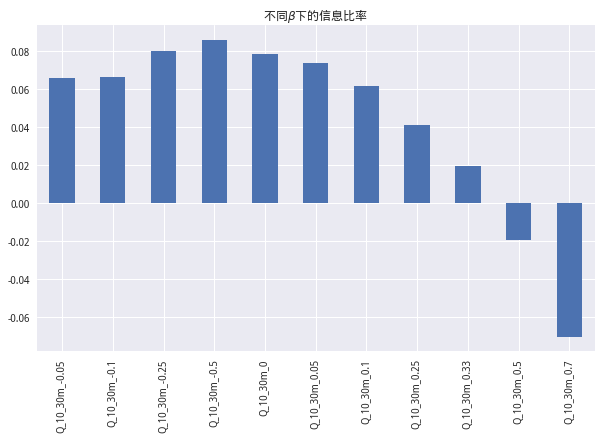

In [68]:
(risk_indicator_tear(excess_ret)['IR'].iloc[:-1]
                    .plot
                    .bar(color='#4C72B0',title=r'不同$\beta$下的信息比率',figsize=(10,6)))

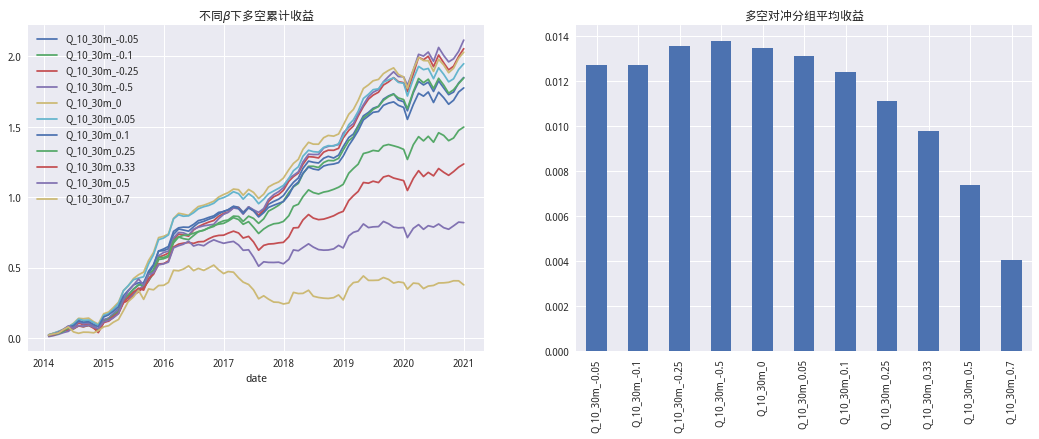

In [53]:
# 画图
mpl.rcParams['font.family']='serif'

fig,cum_axes = plt.subplots(1,2,figsize=(18,6))

ep.cum_returns(excess_ret).plot(title=r'不同$\beta$下多空累计收益',ax=cum_axes[0])
excess_ret.mean().plot.bar(title='多空对冲分组平均收益',color='#4C72B0',ax=cum_axes[1]);

影响实盘的另一个因素是因子的换手率,我们着重对-0.5参数下各组合的换手率进行分析，可以看到各组的月换手特别高平均在80%左右。

In [73]:
# 获取最优组合的换手率
quantile_factor = factor_data.groupby(
    level='date')['Q_10_30m_-0.5'].apply(lambda x: add_group(x))

quantile_factor = quantile_factor.dropna()

quantile_factor.index.names = ['date', 'asset']

# 获取各组换手率
quantile_turnover = pd.concat((perf.quantile_turnover(quantile_factor, q)
                               for q in quantile_factor.sort_values().unique().tolist()), axis=1)

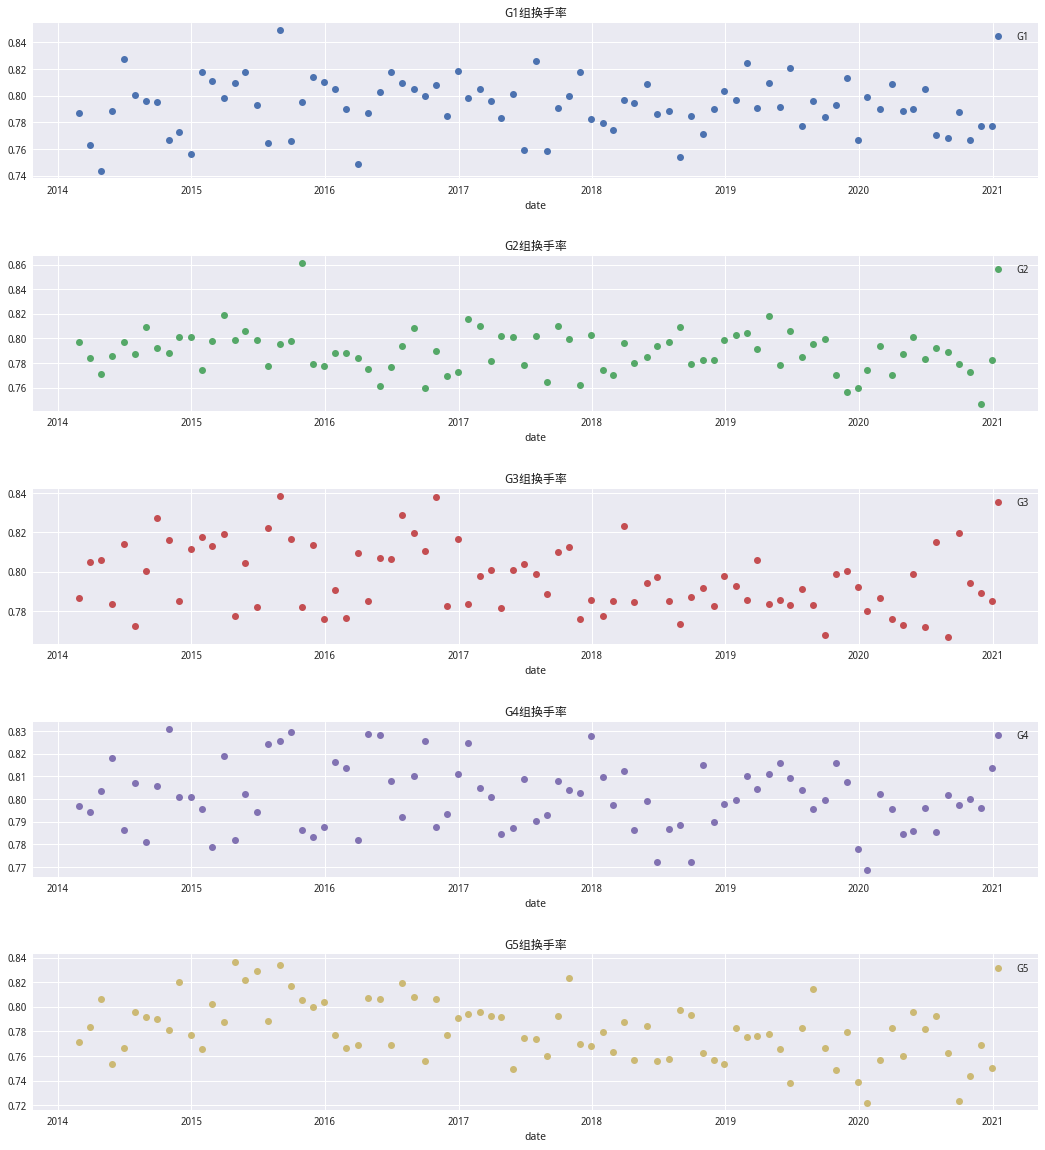

In [109]:
# 画图
quantile_turnover.plot(marker='o', ls='', subplots=True, figsize=(18, 4 * 5), sharex=False,
                       title=[f'{g}组换手率' for g in quantile_factor.sort_values().unique().tolist()])
plt.subplots_adjust(hspace=0.5)

**不同样本空间**


沪深300中的因子表现

In [11]:
# 5m13s
hs300_1 = prepare_data('000300.XSHG','2014-01-01','2020-12-31','2021-01-31',
                           Q_factor,{'func':grid_factor,'params':{'lamb':[-0.5]}})

In [13]:
# 4m44 对数化
hs300_2 = prepare_data('000300.XSHG','2014-01-01','2020-12-31','2021-01-31',
                           Q_factor,{'func':grid_factor,'params':{'lamb':[-0.5]}},mod='ln')

In [41]:
# 获取分组及计算IC

hs300_1['group'] = hs300_1.groupby(
    level='date')['Q_10_30m_-0.5'].transform(add_group)

# 对数
hs300_2['group'] = hs300_2.groupby(
    level='date')['Q_10_30m_-0.5'].transform(add_group)


# 计算IC
hs300_ic_1 = hs300_1.groupby([pd.Grouper(level='date'), 'group'])[
    ['Q_10_30m_-0.5', 'next_ret']].apply(src_ic)
hs300_ic_1 = hs300_ic_1.unstack()['Q_10_30m_-0.5']

# 对数
hs300_ic_2 = hs300_2.groupby([pd.Grouper(level='date'), 'group'])[
    ['Q_10_30m_-0.5', 'next_ret']].apply(src_ic)
hs300_ic_2 = hs300_ic_2.unstack()['Q_10_30m_-0.5']


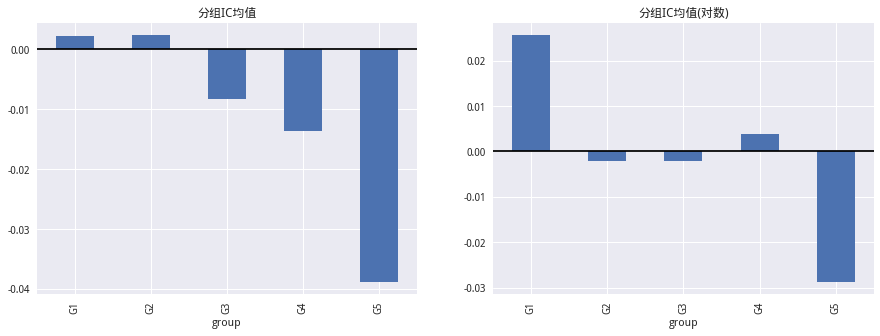

In [47]:
# 分组IC均值图
fig, ic_bar_axes = plt.subplots(1, 2, figsize=(15, 5))

hs300_ic_1.mean().plot.bar(ax=ic_bar_axes[0], title='分组IC均值', color='#4C72B0')
ic_bar_axes[0].axhline(0, color='black')
hs300_ic_2.mean().plot.bar(
    ax=ic_bar_axes[1], title='分组IC均值(对数)', color='#4C72B0')
ic_bar_axes[1].axhline(0, color='black')


In [37]:
# 计算分组收益
hs300_ret1 = get_algorithm_ret(hs300_1,'Q_10_30m_-0.5')
hs300_cum1 = ep.cum_returns(hs300_ret1).add(1)

hs300_ret2 = get_algorithm_ret(hs300_2,'Q_10_30m_-0.5')
hs300_cum2 = ep.cum_returns(hs300_ret2).add(1)

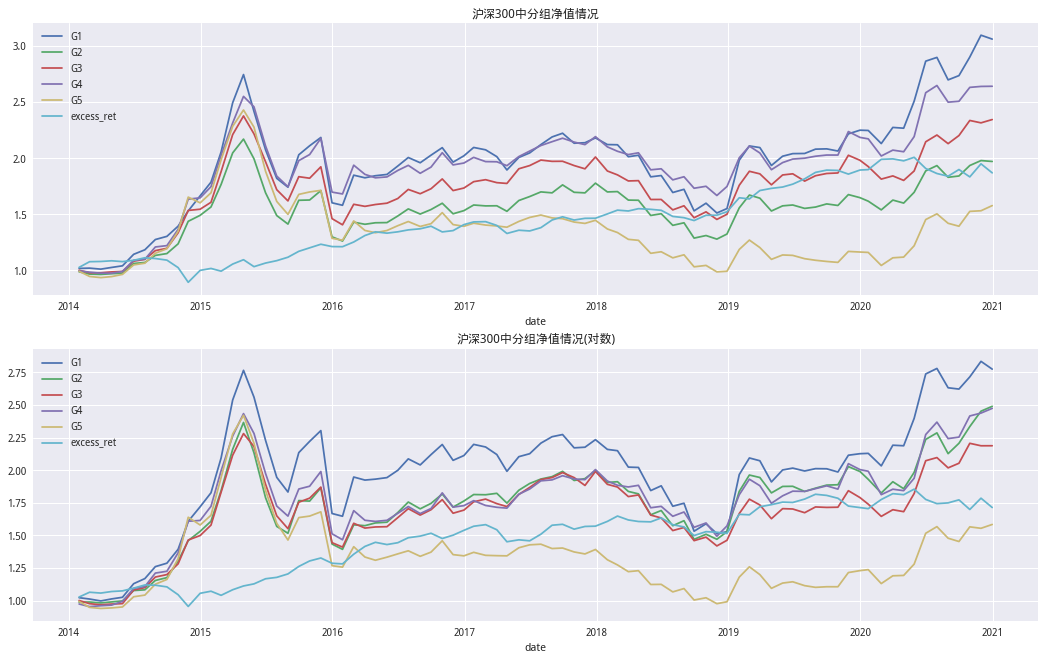

In [49]:
# 画图
fig,cum_axes = plt.subplots(2,figsize=(18,11))

mpl.rcParams['font.family']='serif'
hs300_cum1.plot(title='沪深300中分组净值情况',ax=cum_axes[0])

hs300_cum2.plot(title='沪深300中分组净值情况(对数)',ax=cum_axes[1]);